<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch

import matplotlib.pyplot as plt

import cv2
import numpy as np

import laia.common.logging as log
from laia.common.arguments import add_argument, args, add_defaults
from laia.common.arguments_types import str2bool
from laia.common.loader import ModelLoader, CheckpointLoader
from laia.data import ImageDataLoader, ImageFromListDataset
from laia.decoders import CTCGreedyDecoder
from laia.engine.feeders import ImageFeeder, ItemFeeder
from laia.experiments import Experiment
from laia.utils import SymbolsTable, ImageToTensor
from laia.data import ImageDataLoader, TextImageFromTextTableDataset
import laia.data.transforms as transforms
import multiprocessing
from laia.engine.feeders import ImageFeeder, ItemFeeder
import pickle
import pandas as pd
import os

from tqdm.notebook import tqdm

import editdistance

def compute_cdist(gt, pred):
    return editdistance.eval(gt, pred), len(gt)

def compute_wdist(gt, pred):
    return compute_cdist(chars2words(gt), chars2words(pred))

def compute_cer(gt, pred):
    return editdistance.eval(gt, pred)/len(gt)

def chars2words(chars):
    return "".join(chars).split('@') if isinstance(chars, list) else ""

def compute_wer(gt, pred):
    return compute_cer(chars2words(gt), chars2words(pred))

ModuleNotFoundError: No module named 'torch'

In [59]:
syms = SymbolsTable('/scratch/raphael/phd/htr/PyLaia/egs/vtm/exper/puigcerver17_transfer_bn_dist/train/syms_ctc.txt')
device = torch.device('cuda:0')

train_path = '/scratch/raphael/phd/htr/PyLaia/egs/vtm/exper/puigcerver17_transfer_bn_dist/train'
model_filename = 'model'
checkpoint_filename = 'experiment.ckpt.lowest-valid-cer-68'
gt_path = '/scratch/raphael/phd/htr/laia/egs/vtm/data/lang/split/te.txt'
image_path = '/scratch/raphael/phd/htr/laia/egs/vtm/data/imgs/lines_h128'

In [58]:
syms = SymbolsTable('/scratch/raphael/phd/htr/laia/egs/lausanne-berney/exper/puigcerver17_transfer_bn_dist/train/syms_ctc.txt')
device = torch.device('cpu')

train_path = '/scratch/raphael/phd/htr/laia/egs/lausanne-berney/exper/puigcerver17_transfer_bn_dist/train'
model_filename = 'model'
checkpoint_filename = 'experiment.ckpt.lowest-valid-cer-99'
# checkpoint_filename = 'experiment.ckpt.lowest-valid-wer-103'
gt_path = '/scratch/raphael/phd/htr/laia/egs/lausanne-berney/data/lang/split/te.txt'
image_path = '/scratch/raphael/phd/htr/laia/egs/lausanne-berney/data/imgs/lines_h128'

In [60]:
model = ModelLoader(
        train_path, filename=model_filename, device=device
    ).load()
state = CheckpointLoader(device=device).load_by(
        os.path.join(train_path, checkpoint_filename)
    )
if 'tr_engine' in state:
    state = Experiment.get_model_state_dict(state)
model.load_state_dict(state)
model = model.to(device)
model.eval()

LaiaCRNN(
  (conv): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Leak

In [61]:
dataset = TextImageFromTextTableDataset(
    gt_path,
    image_path,
    img_transform=ImageToTensor(),
    txt_transform=transforms.text.ToTensor(syms),
)
dataset_loader = ImageDataLoader(
    dataset=dataset,
    image_channels=1,
    batch_size=10,
    num_workers=8,
)
batch_input_fn = ImageFeeder(device=device, parent_feeder=ItemFeeder("img"))
batch_target_fn = ItemFeeder("txt")
batch_id_fn = ItemFeeder("id")
decoder = CTCGreedyDecoder()


In [62]:
decoded = []
target = []
ids = []

counter = 0

# Go through all the samples, compute the prediction, get the label
for batch in tqdm(dataset_loader):

    batch_input = batch_input_fn(batch)
    batch_target = batch_target_fn(batch)
    batch_id = batch_id_fn(batch)

    batch_input = batch_input_fn(batch)
    batch_output = model(batch_input)
    batch_decoded = decoder(batch_output)

    decoded.extend(batch_decoded)
    target.extend(batch_target)
    ids.extend(batch_id)

In [63]:
decoded = [[syms[char] for char in entry] for entry in decoded]
target = [[syms[char] if char else "?" for char in entry] for entry in target]
result = pd.DataFrame(zip(ids, target, decoded), columns=['id', 'target', 'decoded']).set_index('id')
result['cer'] = result.apply(lambda row: compute_cer(row['target'], row['decoded']), axis=1)
result['wer'] = result.apply(lambda row: compute_wer(row['target'], row['decoded']), axis=1)
result[['cdist', 'clen']] = result.apply(lambda row: compute_cdist(row['target'], row['decoded']), result_type='expand', axis=1)
result[['wdist', 'wlen']] = result.apply(lambda row: compute_wdist(row['target'], row['decoded']), result_type='expand', axis=1)


In [64]:
result['cdist'].sum()/result['clen'].sum(), result['wdist'].sum()/result['wlen'].sum()

(0.044689174982334594, 0.15065724466269426)

In [65]:
result[['cer', 'wer']].describe()

,cer,wer
count,22105.000000,22105.000000
mean,0.045802,0.144804
std,0.127396,0.297338
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.027778,0.166667
max,4.000000,5.000000


In [82]:
def res2clean(res):
    return "".join(res).replace('@', ' ')
def show_result(result_row):
    img_path = os.path.join(image_path, result_row.name + ".jpg")
    target = res2clean(result_row['target'])
    decoded = res2clean(result_row['decoded'])
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.imread(img_path)[:,:,::-1])
    print(f'Target was "{target}", prediction is "{decoded}"')

id
00137cc7-2006-428f-8140-7db8bb52ea4f    False
00145528-b080-4c14-a0d7-284dd975b0b9    False
0007040a-e8e3-4d5d-98b6-62cb5ae901cd    False
001bafb9-917b-4ee5-bcb1-df0e42916448    False
0010fab0-b935-4354-a166-70dc35cc47f6    False
                                        ...  
fffe90aa-5607-4d69-943a-2f760df5803c     True
fffc7c0b-fdf2-447d-be6c-ac7dded74ddf     True
fffc44fe-7286-4a2f-b967-3d788fa4fb5b    False
fffd73e7-6c73-4efe-a682-41779910330b    False
fffbef42-1970-4eea-808c-6cbc47c19bac    False
Name: wer, Length: 22105, dtype: bool

Target was "bo", prediction is "60"


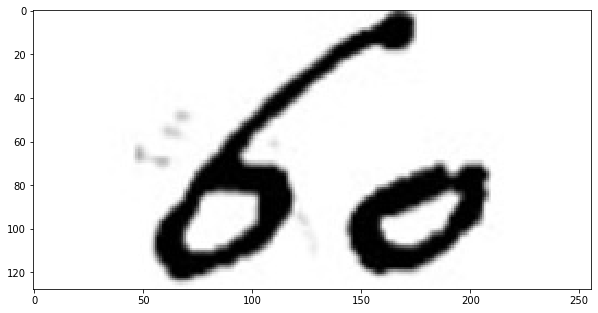

In [148]:
show_result(result.loc[result['cer'] > 0.6].sample(1).iloc[0])

Target was "Caveau", prediction is "Cavcan"


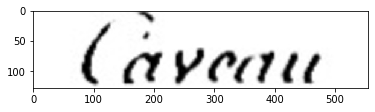

In [57]:
show_result(result.loc['640_folio_001_legende'])

In [52]:
result.loc[result['cer'] > 0]

,target,decoded,cer,wer,cdist,clen,wdist,wlen
id,,,,,,,,
150_folio_001_legende,"[N, °, s]","[N, e, s]",0.333333,1.0,1,3,1,1
175_folio_001_legende,"[2, 0, 6, 0]","[2, 0, 0, 0]",0.250000,1.0,1,4,1,1
156_folio_001_legende,[0],[1],1.000000,1.0,1,1,1,1
241_folio_001_legende,"[F, a, v, e, z]","[J, a, v, e, z]",0.200000,1.0,1,5,1,1
304_folio_001_legende,"[A, l, e, x, a, n, d, r, i, n, e]","[A, t, s, a, n, d, r, i, n, e]",0.272727,1.0,3,11,1,1
50_folio_001_legende,"[T, e, r, r, a, s, s, e]","[F, e, r, r, a, s, s, e]",0.125000,1.0,1,8,1,1
537_folio_001_legende,"[N, °, s]","[N, 2]",0.666667,1.0,2,3,1,1
640_folio_001_legende,"[C, a, v, e, a, u]","[C, a, v, c, a, n]",0.333333,1.0,2,6,1,1
658_folio_001_legende,"[é, t, a, b, l, e]","[é, l, a, b, l, e]",0.166667,1.0,1,6,1,1


In [33]:
result[result['cer'] ==0]

,id,target,decoded,cer,wer,cdist,clen,wdist,wlen
0,132_folio_001_legende,"[S, u, s, a, n, n, e]","[S, u, s, a, n, n, e]",0.0,0.0,0,7,0,1
1,112_folio_001_legende,"[s, o, u, s]","[s, o, u, s]",0.0,0.0,0,4,0,1
2,111_folio_001_legende,"[p, r, e, s, s, o, i, r]","[p, r, e, s, s, o, i, r]",0.0,0.0,0,8,0,1
3,134_folio_001_legende,"[P, i, e, r, r, e]","[P, i, e, r, r, e]",0.0,0.0,0,6,0,1
4,128_folio_001_legende,"[L, e, r, b, e, r]","[L, e, r, b, e, r]",0.0,0.0,0,6,0,1
...,...,...,...,...,...,...,...,...,...
163,841_folio_001_legende,[.],[.],0.0,0.0,0,1,0,1
164,835_folio_001_legende,[.],[.],0.0,0.0,0,1,0,1
165,88_folio_001_legende,"[B, u, a, n, d, e, r, i, e]","[B, u, a, n, d, e, r, i, e]",0.0,0.0,0,9,0,1
166,95_folio_001_legende,"[u, n, e]","[u, n, e]",0.0,0.0,0,3,0,1


In [62]:
idx = 0

Target was "Kham", prediction is "Pham"


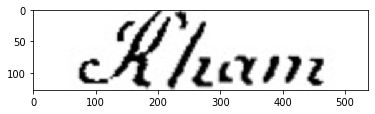

In [77]:
show_result(result.loc[result['cer'] > 0].iloc[idx])
idx += 1

- Evalutation par écriture.
- Ne pas enlever le background -> pour ne pas fausser la layout.
- Enlever les parties imprimées.

In [93]:
with open('/scratch/raphael/phd/htr/laia/egs/lausanne-berney/data/lang/all/char.txt', 'r') as infile:
    lines = infile.readlines()

In [98]:
data = [(x.strip().split()[0], x.strip().split()[1:]) for x in lines]

In [99]:
from collections import Counter

In [100]:
char_counter = Counter()

In [101]:
for _, chars in data:
    char_counter.update(chars)

In [107]:
len()

[('e', 283),
 ('a', 167),
 ('i', 141),
 ('n', 134),
 ('s', 124),
 ('r', 122),
 ('o', 116),
 ('u', 98),
 ('l', 75),
 ('d', 68),
 ('2', 52),
 ('f', 51),
 ('t', 48),
 ('c', 43),
 ('M', 39),
 ('J', 38),
 ('m', 32),
 ('9', 31),
 ('0', 27),
 ('8', 26),
 ('h', 25),
 ('3', 23),
 ('L', 23),
 ('7', 23),
 ('1', 22),
 ('4', 21),
 ('P', 21),
 ('B', 20),
 ('S', 18),
 ('p', 17),
 ('A', 16),
 ('F', 16),
 ('5', 16),
 ('C', 14),
 ('D', 13),
 ('6', 13),
 ('ç', 12),
 ('g', 10),
 ('y', 9),
 ('é', 9),
 ('v', 8),
 ('b', 6),
 ('N', 5),
 ('R', 5),
 ('G', 5),
 ('V', 5),
 ('z', 4),
 ("'", 4),
 ('q', 4),
 ('°', 3),
 ('E', 3),
 ('T', 2),
 ('ê', 2),
 ('^', 2),
 ('j', 2),
 ('à', 2),
 ('K', 2),
 ('x', 1),
 ('H', 1),
 ('I', 1),
 ('.', 1)]